# Reinforcement Learning based Trading Strategy

In this case study, we will create an end-to-end trading strategy based on Reinforcement Learning.


## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
* [5.Evaluate Algorithms and Models](#5)
    * [5.1. Train Test Split](#5.1)
    * [5.2. Implementation steps and modules](#5.2)
    * [5.3. Agent Script](#5.3)
    * [5.4. Helper Function](#5.4)
    * [5.5. Training Set](#5.5)       

* [6.Test Set](#6)           

<a id='0'></a>
# 1. Problem Definition

In this Reinforcement Learning framework for trading strategy, the algorithm takes an action (buy, sell or hold) depending upon the current state of the stock price. The algorithm is trained using Deep Q-Learning framework, to help us predict
the best action, based on the current stock prices.

The key components of the RL based framework are :
* Agent: Trading agent.
* Action: Buy, sell or hold.
* Reward function: Realized profit and loss (PnL) is used as the reward function
for this case study. The reward depends upon the action:
    * Sell: Realized profit and loss (sell price - bought price)
    * Buy: No reward
    * Hold: No Reward

* State: Differences of past stock prices for a given time window is used as the state.

The data used for this case study will be the standard and poor's 500. The link to the data is : https://ca.finance.yahoo.com/quote/%255EGSPC/history?p=%255EGSPC).

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# !git clone "https://github.com/Likelipop/Lab_Python_DS.git"
# %cd "Lab_Python_DS"

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import requests
from bs4 import BeautifulSoup
import zipfile
import io

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque

<a id='1.2'></a>
## 2.2. Loading the Data

In [4]:
url = 'https://cafef1.mediacdn.vn/data/ami_data/20241218/CafeF.SolieuGD.Upto18122024.zip'

In [5]:
response = requests.get(url)

In [6]:
if response.status_code == 200: print("Tệp ZIP đã được tải thành công!")

Tệp ZIP đã được tải thành công!


In [7]:
# Bước 2: Giải nén tệp ZIP
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # Liệt kê tất cả các tệp trong ZIP
    zip_file_names = zip_ref.namelist()
    print("Danh sách các tệp trong ZIP:")

    # Tạo danh sách các tệp CSV trong tệp ZIP
    csv_files = [file_name for file_name in zip_file_names if file_name.endswith('.csv')]

    if csv_files:
        # Hiển thị danh sách các tệp CSV để người dùng chọn
        print("\nCác tệp CSV có trong tệp ZIP:")
        for idx, file in enumerate(csv_files):
            print(f"{idx + 1}. {file}")

        # Bước 3: Yêu cầu người dùng chọn tệp CSV
        try:
            choice = 1
            if 0 <= choice < len(csv_files):
                selected_file = csv_files[choice]
                print(f"\nBạn đã chọn tệp: {selected_file}")

                # Đọc tệp CSV vào pandas DataFrame
                with zip_ref.open(selected_file) as file:
                    dataset = pd.read_csv(file)
                    print("\nDữ liệu từ CSV:")
                    print(dataset.head())  # In 5 dòng đầu của dữ liệu CSV
            else:
                print("Lựa chọn không hợp lệ.")
        except ValueError:
            print("Vui lòng nhập một số hợp lệ.")
    else:
        print("Không tìm thấy tệp CSV trong ZIP.")

Danh sách các tệp trong ZIP:

Các tệp CSV có trong tệp ZIP:
1. CafeF.HSX.Upto18.12.2024.csv
2. CafeF.HNX.Upto18.12.2024.csv
3. CafeF.UPCOM.Upto18.12.2024.csv

Bạn đã chọn tệp: CafeF.HNX.Upto18.12.2024.csv

Dữ liệu từ CSV:
  <Ticker>  <DTYYYYMMDD>  <Open>  <High>  <Low>  <Close>  <Volume>
0      AAV      20241218     7.7     7.9    7.6      7.6    863043
1      ADC      20241218    21.0    21.0   21.0     21.0         8
2      ALT      20241218    11.9    11.9   11.9     11.9       100
3      AME      20241218     4.7     4.7    4.7      4.7       465
4      API      20241218     8.1     8.2    7.8      8.0    604506


In [8]:
dataset.head()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,AAV,20241218,7.7,7.9,7.6,7.6,863043
1,ADC,20241218,21.0,21.0,21.0,21.0,8
2,ALT,20241218,11.9,11.9,11.9,11.9,100
3,AME,20241218,4.7,4.7,4.7,4.7,465
4,API,20241218,8.1,8.2,7.8,8.0,604506


In [9]:
#The data already obtained from yahoo finance is imported.
# dataset = read_csv('/content/drive/MyDrive/year4/PY/HNX.Upto13.12.2024.csv',index_col=0)

In [10]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

In [12]:
# shape
dataset.shape

(832202, 7)

In [13]:
dataset.head(5)

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,AAV,20241218,7.7,7.9,7.6,7.6,863043
1,ADC,20241218,21.0,21.0,21.0,21.0,8
2,ALT,20241218,11.9,11.9,11.9,11.9,100
3,AME,20241218,4.7,4.7,4.7,4.7,465
4,API,20241218,8.1,8.2,7.8,8.0,604506


The data has total 2515 rows and six columns which contain the open, high, low,
close and adjusted close price along with the total volume. The adjusted close is the
closing price adjusted for the split and dividends. For the purpose of this case study,
we will be focusing on the closing price.

In [14]:
# Hiển thị tên các cột
print(dataset.columns)

Index(['<Ticker>', '<DTYYYYMMDD>', '<Open>', '<High>', '<Low>', '<Close>',
       '<Volume>'],
      dtype='object')


In [15]:
# Lấy danh sách các ticker duy nhất từ cột <Ticker>
unique_tickers = dataset['<Ticker>'].unique()

# Hiển thị danh sách các ticker
print(unique_tickers)

print("có", unique_tickers.shape, "Công ty")


['AAV' 'ADC' 'ALT' 'AME' 'API' 'APS' 'ARM' 'ATS' 'BAB' 'BAX' 'BCC' 'BCF'
 'BKC' 'BNA' 'BST' 'BTS' 'BTW' 'BVS' 'C69' 'CAG' 'CAP' 'CAR' 'CDN' 'CEO'
 'CET' 'CIA' 'CLH' 'CLM' 'CMS' 'CPC' 'CSC' 'CTP' 'CX8' 'D11' 'DAD' 'DAE'
 'DC2' 'DDG' 'DHP' 'DHT' 'DIH' 'DL1' 'DNC' 'DNP' 'DP3' 'DS3' 'DST' 'DTC'
 'DTD' 'DTG' 'DTK' 'DVM' 'DXP' 'EBS' 'EID' 'EVS' 'GDW' 'GIC' 'GKM' 'GLT'
 'GMX' 'HBS' 'HCC' 'HDA' 'HGM' 'HHC' 'HKT' 'HLC' 'HLD' 'HMH' 'HMR' 'HOM'
 'HUT' 'HVT' 'IDC' 'IDJ' 'IDV' 'INC' 'INN' 'IPA' 'ITQ' 'IVS' 'KDM' 'KHS'
 'KKC' 'KSD' 'KSF' 'KSQ' 'KSV' 'KTS' 'L14' 'L18' 'L40' 'LAS' 'LDP' 'LHC'
 'LIG' 'MAC' 'MBG' 'MBS' 'MCO' 'MDC' 'MED' 'MEL' 'MKV' 'MST' 'MVB' 'NAG'
 'NBC' 'NBP' 'NBW' 'NDN' 'NDX' 'NET' 'NHC' 'NRC' 'NSH' 'NTP' 'NVB' 'OCH'
 'ONE' 'PBP' 'PCE' 'PCG' 'PCH' 'PCT' 'PDB' 'PGN' 'PGS' 'PGT' 'PIC' 'PLC'
 'PMB' 'PMC' 'POT' 'PPP' 'PPS' 'PPT' 'PPY' 'PRC' 'PRE' 'PSD' 'PSI' 'PSW'
 'PTI' 'PTX' 'PV2' 'PVB' 'PVC' 'PVG' 'PVI' 'PVS' 'QTC' 'RCL' 'S99' 'SAF'
 'SCG' 'SCI' 'SD5' 'SD9' 'SDA' 'SDN' 'SED' 'SGC' 'S

In [16]:
# Thêm cột <Adj Close> với giá trị bằng cột <Close>
dataset['<Adj Close>'] = dataset['<Close>']

# Sắp xếp lại các cột để đưa <Adj Close> vào giữa <Close> và <Volume>
cols = ['<Ticker>', '<DTYYYYMMDD>', '<Open>', '<High>', '<Low>', '<Close>', '<Adj Close>', '<Volume>']
dataset = dataset[cols]

# Hiển thị dữ liệu sau khi sắp xếp cột
print(dataset)

       <Ticker>  <DTYYYYMMDD>   <Open>   <High>    <Low>  <Close>  \
0           AAV      20241218   7.7000   7.9000   7.6000   7.6000   
1           ADC      20241218  21.0000  21.0000  21.0000  21.0000   
2           ALT      20241218  11.9000  11.9000  11.9000  11.9000   
3           AME      20241218   4.7000   4.7000   4.7000   4.7000   
4           API      20241218   8.1000   8.2000   7.8000   8.0000   
...         ...           ...      ...      ...      ...      ...   
832197      SGH      20010725   5.2349   5.2349   5.2349   5.2375   
832198      SGH      20010723   4.8997   4.8997   4.8997   4.9022   
832199      SGH      20010720   4.5805   4.5805   4.5805   4.5828   
832200      SGH      20010718   4.2932   4.2932   4.2932   4.2954   
832201      SGH      20010716   4.0219   4.0219   4.0219   4.0239   

        <Adj Close>  <Volume>  
0            7.6000    863043  
1           21.0000         8  
2           11.9000       100  
3            4.7000       465  
4          

In [17]:
# Chuyển cột <DTYYYYMMDD> thành định dạng datetime nếu cần thiết
dataset['<DTYYYYMMDD>'] = pd.to_datetime(dataset['<DTYYYYMMDD>'], format='%Y%m%d')

# Lọc dữ liệu từ 20201201 đến 20241218
start_date = '2020-12-01'
end_date = '2024-12-18'
filtered_data = dataset[(dataset['<DTYYYYMMDD>'] >= start_date) & (dataset['<DTYYYYMMDD>'] <= end_date)]

# Hiển thị dữ liệu đã lọc
print(filtered_data)

# Lưu dataset mới vào file CSV nếu cần
# filtered_data.to_csv("filtered_dataset.csv", index=False)

       <Ticker> <DTYYYYMMDD>    <Open>    <High>     <Low>   <Close>  \
0           AAV   2024-12-18    7.7000    7.9000    7.6000    7.6000   
1           ADC   2024-12-18   21.0000   21.0000   21.0000   21.0000   
2           ALT   2024-12-18   11.9000   11.9000   11.9000   11.9000   
3           AME   2024-12-18    4.7000    4.7000    4.7000    4.7000   
4           API   2024-12-18    8.1000    8.2000    7.8000    8.0000   
...         ...          ...       ...       ...       ...       ...   
248176      VSA   2020-12-01   10.8960   10.8960   10.8960   10.8974   
248177      VSM   2020-12-01   10.6459   10.6459    8.7370    8.7378   
248178      VTC   2020-12-01    6.3634    7.1490    6.2848    7.1491   
248179      WCS   2020-12-01  193.7180  194.6770  193.7180  193.7258   
248180      WSS   2020-12-01    2.2000    2.3000    2.2000    2.3000   

        <Adj Close>  <Volume>  
0            7.6000    863043  
1           21.0000         8  
2           11.9000       100  
3      

In [18]:
# Lọc tất cả các hàng liên quan đến Ticker = AAV:
# Lọc các hàng có giá trị 'AAV' trong cột <Ticker>
ticker_aav_dataset = filtered_data[filtered_data['<Ticker>'] == 'AAV']

# Hiển thị dữ liệu đã lọc
print(ticker_aav_dataset)


# Lưu dataset mới vào file CSV nếu cần
#ticker_aav.to_csv("ticker_aav_dataset.csv", index=False)

       <Ticker> <DTYYYYMMDD>  <Open>  <High>   <Low>  <Close>  <Adj Close>  \
0           AAV   2024-12-18  7.7000  7.9000  7.6000   7.6000       7.6000   
228         AAV   2024-12-17  7.7000  7.8000  7.5000   7.6000       7.6000   
453         AAV   2024-12-16  7.6000  7.7000  7.5000   7.6000       7.6000   
687         AAV   2024-12-13  7.6000  7.8000  7.4000   7.6000       7.6000   
918         AAV   2024-12-12  7.9000  7.9000  7.6000   7.6000       7.6000   
...         ...          ...     ...     ...     ...      ...          ...   
247121      AAV   2020-12-07  7.8139  8.5700  7.8139   8.3181       8.3181   
247341      AAV   2020-12-04  7.6458  7.8139  7.4778   7.8139       7.8139   
247560      AAV   2020-12-03  6.9737  7.6458  6.9737   7.5619       7.5619   
247764      AAV   2020-12-02  6.6376  6.9737  6.4695   6.9737       6.9737   
247967      AAV   2020-12-01  6.3855  6.7216  5.8814   6.6376       6.6376   

        <Volume>  
0         863043  
228       515064  
453   

In [19]:
cols1 = ['<DTYYYYMMDD>', '<Open>', '<High>', '<Low>', '<Close>', '<Adj Close>', '<Volume>']
ticker_aav_dataset = ticker_aav_dataset[cols1]
# Hiển thị dữ liệu đã lọc
print(ticker_aav_dataset)

       <DTYYYYMMDD>  <Open>  <High>   <Low>  <Close>  <Adj Close>  <Volume>
0        2024-12-18  7.7000  7.9000  7.6000   7.6000       7.6000    863043
228      2024-12-17  7.7000  7.8000  7.5000   7.6000       7.6000    515064
453      2024-12-16  7.6000  7.7000  7.5000   7.6000       7.6000    449089
687      2024-12-13  7.6000  7.8000  7.4000   7.6000       7.6000    715310
918      2024-12-12  7.9000  7.9000  7.6000   7.6000       7.6000    622878
...             ...     ...     ...     ...      ...          ...       ...
247121   2020-12-07  7.8139  8.5700  7.8139   8.3181       8.3181    891684
247341   2020-12-04  7.6458  7.8139  7.4778   7.8139       7.8139    589220
247560   2020-12-03  6.9737  7.6458  6.9737   7.5619       7.5619    580960
247764   2020-12-02  6.6376  6.9737  6.4695   6.9737       6.9737    517225
247967   2020-12-01  6.3855  6.7216  5.8814   6.6376       6.6376    345490

[1010 rows x 7 columns]


In [20]:
# Thiết lập cột '<DTYYYYMMDD>' làm chỉ số nếu cần
ticker_aav_dataset.set_index('<DTYYYYMMDD>', inplace=True)

In [21]:
ticker_aav_dataset.head(5)

,<Open>,<High>,<Low>,<Close>,<Adj Close>,<Volume>
<DTYYYYMMDD>,,,,,,
2024-12-18,7.7,7.9,7.6,7.6,7.6,863043
2024-12-17,7.7,7.8,7.5,7.6,7.6,515064
2024-12-16,7.6,7.7,7.5,7.6,7.6,449089
2024-12-13,7.6,7.8,7.4,7.6,7.6,715310
2024-12-12,7.9,7.9,7.6,7.6,7.6,622878


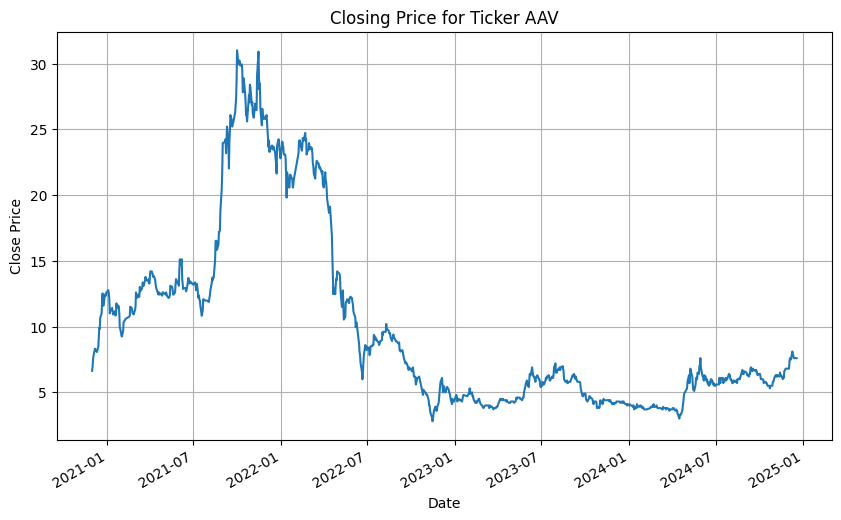

In [22]:
ticker_aav_dataset['<Close>'].plot(figsize=(10, 6), title='Closing Price for Ticker AAV', xlabel='Date', ylabel='Close Price')
plt.grid()
plt.show()

In [23]:
# describe data
set_option('display.precision', 3)
ticker_aav_dataset.describe()

,<Open>,<High>,<Low>,<Close>,<Adj Close>,<Volume>
count,1010.000,1010.000,1010.000,1010.000,1010.000,1.010e+03
mean,9.948,10.238,9.655,9.933,9.933,6.030e+05
std,6.971,7.172,6.788,6.955,6.955,6.189e+05
min,2.600,3.000,2.600,2.800,2.800,3.666e+04
25%,4.725,4.925,4.600,4.800,4.800,2.381e+05
50%,6.600,6.800,6.300,6.600,6.600,3.958e+05
75%,12.603,13.023,12.246,12.603,12.603,7.770e+05
max,31.208,32.851,29.952,31.015,31.015,5.705e+06


Let us look at the plot of the stock movement.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column

In [24]:
#Checking for any null values and removing the null values'''
print('Null Values =',ticker_aav_dataset.isnull().values.any())

Null Values = False


In case there are null values fill the missing values with the last value available in the dataset.

In [25]:
# Fill the missing values with the last value available in the dataset.
ticker_aav_dataset=ticker_aav_dataset.fillna(method='ffill')
ticker_aav_dataset.head(5)

,<Open>,<High>,<Low>,<Close>,<Adj Close>,<Volume>
<DTYYYYMMDD>,,,,,,
2024-12-18,7.7,7.9,7.6,7.6,7.6,863043
2024-12-17,7.7,7.8,7.5,7.6,7.6,515064
2024-12-16,7.6,7.7,7.5,7.6,7.6,449089
2024-12-13,7.6,7.8,7.4,7.6,7.6,715310
2024-12-12,7.9,7.9,7.6,7.6,7.6,622878


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='5.1'></a>
## 5.1. Train Test Split

We will use 80% of the dataset for modeling
and use 20% for testing.

In [26]:
X=list(ticker_aav_dataset["<Close>"])
X=[float(x) for x in X]

In [27]:
validation_size = 0.6
#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In [ ]:
len(X_train)

808

<a id='5.2'></a>
## 5.2. Implementation steps and modules

Ta quan tâm việc tạo ra một **thực thể** mà tại đó nó có nhiệm vụ rằng quyết định liệu có nên **mua, bán hay giữ**, khi được cung cấp giá thị trường hiện tại (và được phép nhìn lại cả trạng thái thị trường trong quá khứ).

Vói dữ liệu chứng khoán như thế này, chúng em xin phép bỏ qua các vấn đề phức tạp khác liên quan đến lĩnh vực tài chính nói chung, và tập trung vào chuyện nắm bắt các hình mẫu của thị trường từ đó để đưa ra các giao dịch. Với trường hợp cơ bản nhất, chúng em cho phép **thực thể** trên, mỗi ngày, được đưa ra 1 trong 3 quyết định bao gồm:


1.   **Mua** : mua một đơn vị cổ phiếu
2.   **Bán** : bán một đơn vị cổ phiểu (tính lời dựa trên vào ngày mua gần nhất và ngày bán hôm nay)
3.   **Giữ** : không làm gì hết.

Ta xem qua công thức Bellman chô Q-value:
$$
Q(s, a) = R(s, a) + \gamma \sum_{s'} P(s'|s, a) \max_{a'} Q(s', a')$$

1. **Q(s, a)** là Q-value, đại diện cho giá trị kỳ vọng của việc
thực hiện hành động a trong trạng thái s.
2. **R(s, a)** là phần thưởng tức thời nhận được sau khi thực hiện hành động a trong trạng thái s.
3. **γ** là hệ số chiết khấu, xác định tầm quan trọng của phần thưởng trong tương lai so với phần thưởng hiện tại.
4. **P(s'|s, a)** là xác suất chuyển đổi từ trạng thái s sang trạng thái s' khi thực hiện hành động a.
5. **max Q(s', a')**là giá trị Q tối đa cho trạng thái tiếp theo s', được tính bằng cách chọn hành động a' tối ưu hóa Q-value.

Còn dưới đây là một dạng đơn giản hơn của Bellman Equation:

$$
v(s) = \max_a \left[ R(s, a) + \gamma \sum_{s'} P(s'|s, a) v(s') \right]
$$

Trong đó:

*   $v(s)$: Hàm giá trị của trạng thái $s$.
*   $\max_a$: Tối đa hóa trên tất cả các hành động có thể $a$ trong trạng thái $s$.
*   $R(s, a)$: Phần thưởng tức thời khi thực hiện hành động $a$ trong trạng thái $s$.
*   $\gamma$: Hệ số chiết khấu.
*   $\sum_{s'}$: Tổng trên tất cả các trạng thái tiếp theo có thể $s'$.
*   $P(s'|s, a)$: Xác suất chuyển đổi từ trạng thái $s$ sang trạng thái $s'$ khi thực hiện hành động $a$.
*   $v(s')$: Hàm giá trị của trạng thái tiếp theo $s'$.


Để triển khai thuật toán DQN này, nhiều hàm và mô-đun được triển khai và tương tác với nhau trong quá trình huấn luyện mô hình. Dưới đây là tổng quan về các mô-đun và hàm:

1. **Lớp Agent**: Agent được định nghĩa là lớp “Agent”. Đối tượng của lớp “Agent” được tạo ra trong giai đoạn huấn luyện và được sử dụng để huấn luyện mô hình.
2. **Các hàm hỗ trợ**: Trong mô-đun này, chúng em viết các hàm bỗ trợ để tiện trong việc xử lý: vd hàm sigmoid(), hàm getstate(), hàm act().  
3. **Mô-đun huấn luyện**: Trong bước này, chúng em thực hiện huấn luyện dữ liệu bằng cách sử dụng các **thực thể** đưa ra một trong ba hành động (tức là mua, bán hoặc giữ) dựa trên các trạng thái của giá cổ phiếu vào cuối ngày. Trong quá trình huấn luyện, hành động được chỉ định cho mỗi ngày được đưa ra, sau đó phần thưởng được tính toán và các trọng số của mô hình Q-learning dựa trên deep-learning được cập nhật liên tục qua nhiều tập. Ngoài ra, lợi nhuận của mỗi hành động được tổng hợp để xem liệu đã có lợi nhuận tổng thể hay chưa. Mục tiêu là tối đa hóa **tổng lợi nhuận**.


<a id='5.3'></a>
## 5.3. Agent script

The definition of the Agent script is the key step, as it consists of the In this section, we will train an agent that will perform reinforcement learning based on the Q-Learning. We will perform the following steps to achieve this:

* Create an agent class whose initial function takes in the batch size, state size, and an evaluation Boolean function, to check whether the training is ongoing.
* In the agent class, create the following methods:
    * Constructor: The constructor inititalises all the parameters.
    * Model : This f unction has a deep learning model to map the state to action.
    * Act function :Returns an action, given a state, using the  output of the model function. The number of actions are defined as 3: sit, buy, sell
    * expReplay : Create a Replay function that adds, samples, and evaluates a buffer. Add a new experience to the replay buffer memory. Randomly sample a batch of experienced tuples from the memory. In the following function, we randomly sample states from a memory buffer. Experience replay stores a history of state, action, reward, and next state transitions that are experienced by the agent. It randomly samples mini-batches from this experience to update the network weights at each time step before the agent selects an ε-greedy action.

Experience replay increases sample efficiency, reduces the autocorrelation of samples that are collected during online learning, and limits the feedback due to the current weights producing training samples that can lead to local minima or divergence.

In [49]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace
import time
import numpy as np
import random
from collections import deque

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size # normalized previous days,
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.8989
        #self.epsilon_decay = 0.9
        #         <explore: lấy đại>     <exploit: vận dụng>
        # random: ưu tiên       ưu tiên
        # time: -------------------------------------------->
        #self.model = self._model()
        #       1 * 0.9 = 0.9        0.9*0.9 = 0.81         0.81**0.9 = 0.7xx  .....  0.01
        # n = random(0,1):
        # nếu n nằm trong (epsilon,1) thì exploit
        # ngược  lại thì explore

        # time: -------------------------------------------->

        self.model = load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.02))
        return model

    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.

    def act(self, state):
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state, verbose =0)
        #set_trace()
        #action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])

        # the memory during the training phase.
        for state, action, reward, next_state, done in mini_batch:
            # start_t = time.time()
            target = reward # reward or Q at time t
            #update the Q table based on Q table equation
            #set_trace()
            if not done:
                #set_trace()
                #max of the array of the predicted.
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose =0)[0])

            # Q-value of the state currently from the table
            target_f = self.model.predict(state, verbose =0)
            # Update the output Q table for the given action in the table
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated.
            self.model.fit(state, target_f, epochs=1, verbose=0)
            # end_t = time.time()

            # print(f" \n time {end_t - start_t}")


        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

<a id='5.4'></a>
## 5.4. Helper Functions

In this script, we will create functions that will be helpful for training. We create the following functions:

1) formatPrice:format the price to two decimal places, to reduce the ambiguity of the data:

2) getStockData: Return a vector of stock data from the CSV file. Convert the closing stock prices from the data to vectors, and return a vector of all stock prices.

3) getState: Define a function to generate states from the input vector. Create the time series by generating the states from the vectors created in the previous step. The function for this takes three parameters: the data; a time, t (the day that you want to predict); and a window (how many days to go back in time). The rate of change between these vectors will then be measured and based on the sigmoid function.

In [29]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t



<a id='5.5'></a>
## 5.5. Training the data

We will proceed to train the data, based on our agent and helper methods. This will provide us with one of three actions, based on the states of the stock prices at the end of the day. These states can be to buy, sell, or hold. During training, the prescribed action for each day is predicted, and the price (profit, loss, or unchanged) of the action is calculated. The cumulative sum will be calculated at the end of the training period, and we will see whether there has been a profit or a loss. The aim is to maximize the total profit.

Steps:
* Define the number of market days to consider as the window size and define the batch size with which the neural network will be trained.
* Instantiate the stock agent with the window size and batch size.
* Read the training data from the CSV file, using the helper function.
* The episode count is defined. The agent will look at the data for so many numbers of times. An episode represents a complete pass over the data.
* We can start to iterate through the episodes.
* Each episode has to be started with a state based on the data and window size. The inventory of stocks is initialized before going through the data.
* **Start to iterate over every day of the stock data. The action probability is predicted by the agent**.
* Next, every day of trading is iterated, and the agent can act upon the data. Every day, the agent decides an action. Based on the action, the stock is held, sold, or bought.
* If the action is 1, then agent buys the stock.
* If the action is 2, the agent sells the stocks and removes it from the inventory. Based on the sale, the profit (or loss) is calculated.

* If the action is 0, then there is no trade. The state can be called holding during that period.
* The details of the state, next state, action etc is saved in the memory of the agent object, which is used further by the exeReply function.       


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class TradingEnv:
    def __init__(self, data, window_size, batch_size, episode_count, learning_interval, is_val = False):
        self.data = data
        self.window_size = window_size
        self.batch_size = batch_size
        self.episode_count = episode_count
        self.learning_interval = learning_interval
        self.agent = Agent(window_size)
        self.state = None
        self.total_profit = 0
        self.inventory = []
        self.states_sell = []
        self.states_buy = []
        self.memory = []
        self.is_val = is_val

    def reset(self):
        self.state = self.getState(0, self.window_size + 1)
        self.total_profit = 0
        self.inventory = []
        self.states_sell = []
        self.states_buy = []
        self.agent.memory = []


    #lấy chênh lệch giá từ ngày t đến ngày t-n+1:
    #nhìn lại n ngày trước đó
    def getState(self, t, n):
        d = t - n + 1
        block = self.data[d:t + 1] if d >= 0 else -d * [self.data[0]] + self.data[0:t + 1] # pad with t0
        #block is which is the for [1283.27002, 1283.27002]
        res = []
        # print(f"n {n}   block {len(block)}")
        for i in range(n - 1):
            res.append(sigmoid(block[i + 1] - block[i]))
        return np.array([res])


    """
    FOR EVERY STATE:
        #1 đưa ra quyết định (mua, giữ, bán)
          #2.1 nhận lấy state tiếp theo (độ chênh giá tính từ ngày mai)
          #2.2 tính toán reward tương ứng cho hành động của mình
        #3 cập nhật memory
        #4 chuyển qua state tiếp theo
        #5 Nếu như tới lúc để cập nhật lại thì gọi replay để cập nhật model
        #5 trả về: (state sau đó, reward tương ứng, và ?đã hết dữ liệu chưa)

    """
    def step(self, t):
        action = self.agent.act(self.state)

        if t != len(self.data) - 1:
          next_state = self.getState(t + 1, self.window_size + 1)
        else :
          next_state = None

        reward = 0

        if action == 1:  # buy
            self.inventory.append(self.data[t])
            self.states_buy.append(t)

        elif action == 2 and len(self.inventory) > 0:  # sell
            bought_price = self.inventory.pop(0)
            reward = max(self.data[t] - bought_price, 0)
            self.total_profit += self.data[t] - bought_price
            self.states_sell.append(t)

        done = t == len(self.data) - 1

        self.agent.memory.append((self.state, action, reward, next_state, done))
        self.state = next_state

        if (len(self.agent.memory) % self.learning_interval == 0) and (len(self.agent.memory) > 0):
          if not self.is_val:
            # print(f" {len(self.agent.memory)}    {self.batch_size}")
            self.agent.expReplay(min(len(self.agent.memory), self.batch_size) )

        return self.state, reward, done

    """
    WORKFLOW:
      #1 với từng episode: (tìm hiểu thêm về episode ?): train lập lại episode_count lần với cùng một weight của model
        #2 dọn memory của models, dọn lại env
        #3 Với từng ngày trôi quá:
          #4 thực hiện công việc trong step (dưa ra action, nhận reward, chuyển trạng thái)
          #5 in kết quả khi chạy xong dữ liệu
        # save models mỗi 2 lần chạy xong episode

    """
    def run(self,tracking = 1):
        for e in range(self.episode_count + 1):
            self.reset()
            print(f"{e}")
            for t in range(len(self.data)):
                # print(f"t {t} ")
                progress_bar(t + 1, len(self.data))
                state, reward, done = self.step(t)
                if done and tracking:
                    print("--------------------------------")
                    print(f"Total Profit: {formatPrice(self.total_profit)}")
                    print("--------------------------------")
                    self.plot_behavior()
                    break
            if (e % 2 == 0) and (not is_val):
                self.agent.model.save(f"model_ep{e}.keras")

    def plot_behavior(self):
        plt.figure(figsize=(10,5))
        plt.plot(self.data, color='r', lw=2.)
        plt.plot(self.data, 'v', markersize=10, color='m', label='Selling signal', markevery=self.states_sell)
        plt.plot(self.data, '^', markersize=10, color='k', label='Buying signal', markevery=self.states_buy)
        plt.title('Total gains: %f'%self.total_profit)
        plt.legend()
        plt.show()


In [31]:
import time
import sys

def progress_bar(current, total, bar_length=20):
    """Hiển thị thanh trạng thái cho env.run.

    Args:
        current: Ngày hiện tại.
        total: Tổng số ngày.
        bar_length: Chiều dài của thanh trạng thái.
    """
    percent = float(current) / total
    arrow = '-' * int(round(percent * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write(f'\rTiến trình: [{arrow}{spaces}] {int(round(percent * 100))}%\t Ngày hiện tại: {current}')
    sys.stdout.flush()

    if current == total:
        sys.stdout.write('\n')
        sys.stdout.flush()

# ... (mã hiện tại của bạn)

0
Tiến trình: [------------------->] 100%	 Ngày hiện tại: 404
--------------------------------
Total Profit: -$1.70
--------------------------------


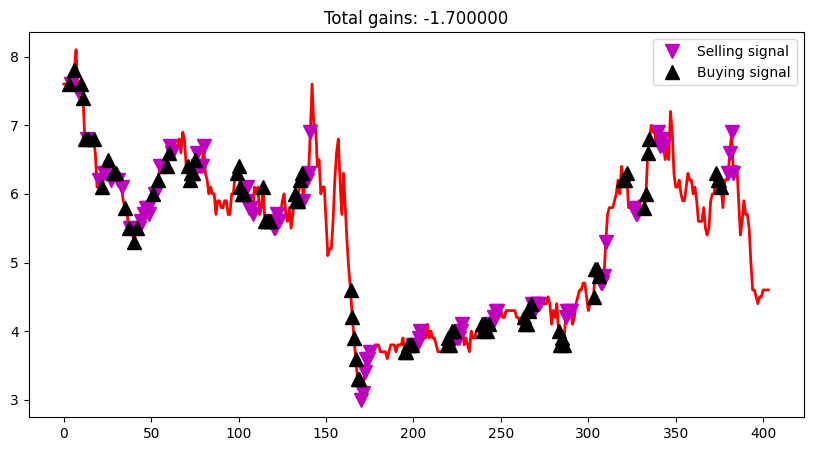

1
Tiến trình: [------------------->] 100%	 Ngày hiện tại: 404
--------------------------------
Total Profit: $0.30
--------------------------------


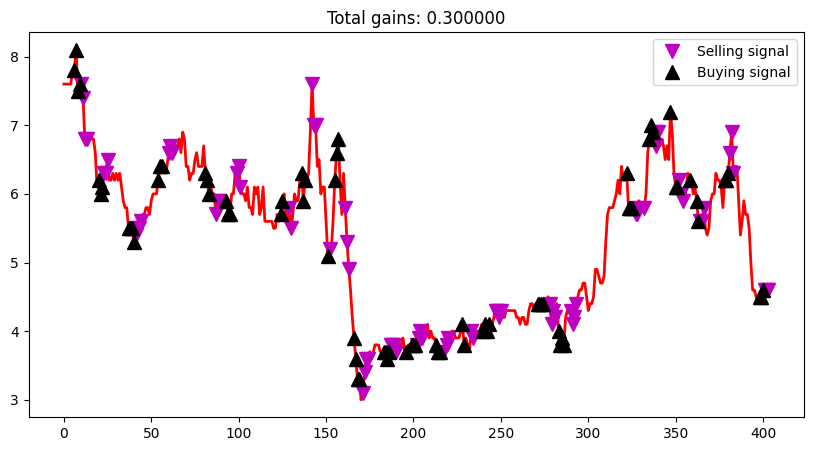

2
Tiến trình: [------------------->] 100%	 Ngày hiện tại: 404
--------------------------------
Total Profit: $2.10
--------------------------------


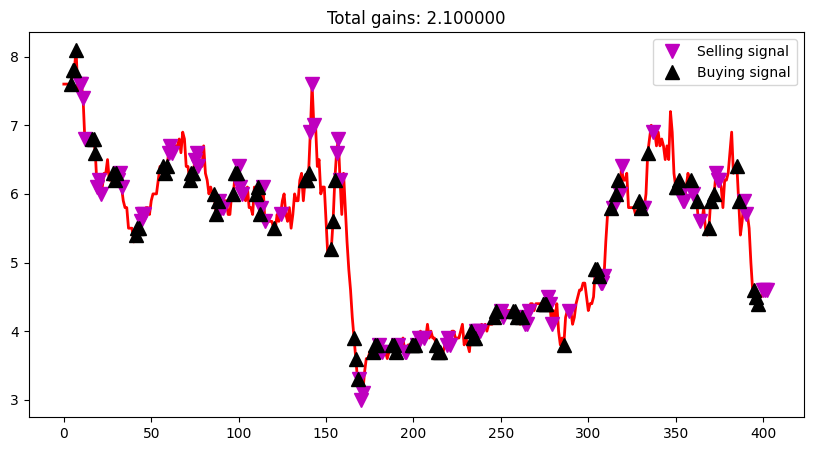

3
Tiến trình: [------------------->] 100%	 Ngày hiện tại: 404
--------------------------------
Total Profit: -$3.30
--------------------------------


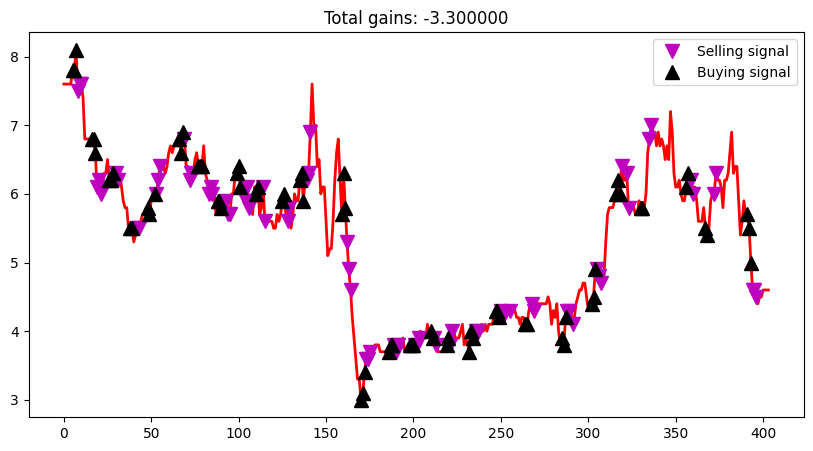

4
Tiến trình: [------------------->] 100%	 Ngày hiện tại: 404
--------------------------------
Total Profit: $0.00
--------------------------------


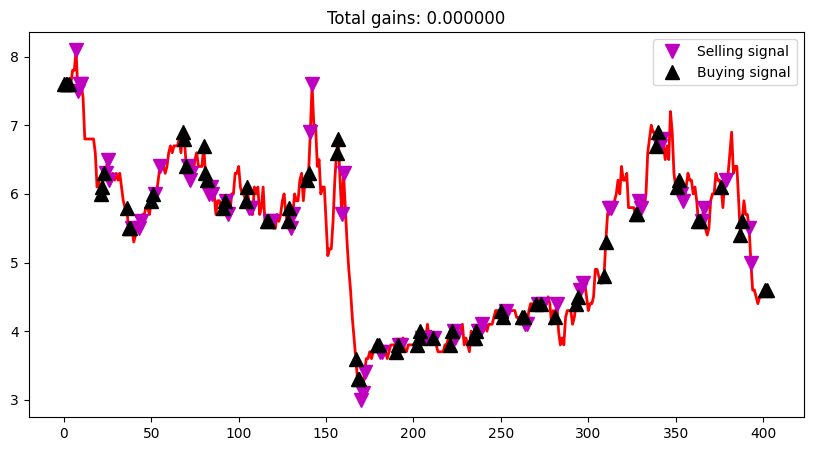

5
Tiến trình: [------------------->] 100%	 Ngày hiện tại: 404
--------------------------------
Total Profit: $0.10
--------------------------------


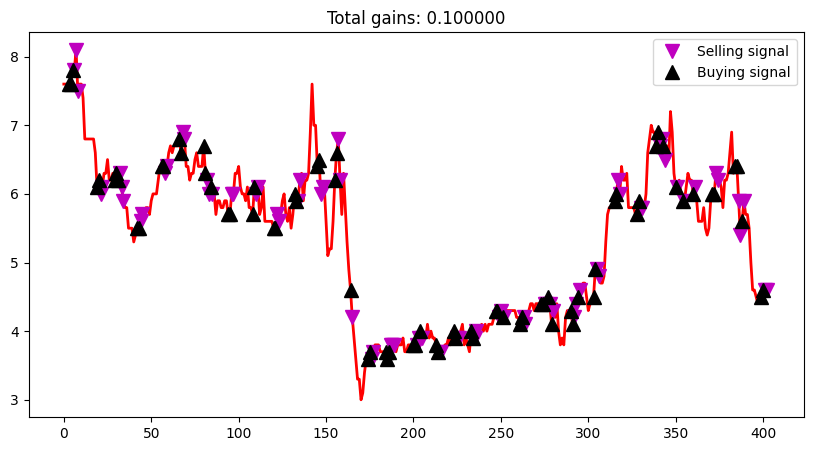

In [32]:
data = X_train
env = TradingEnv(data, window_size=5, batch_size=10, episode_count=5, learning_interval=1)
env.run(tracking = 1)

In [ ]:
#Deep Q-Learning Model
print(env.agent.model.summary())

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)                    │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,075 (12.01 KB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 0 (0.00 B)

None


<a id='6'></a>
# 6. Testing the Data

After training the data, it is tested it against the test dataset. Our model resulted in a overall profit. The best thing about the model was that the profits kept improving over time, indicating that it was learning well and taking better actions.

In [51]:
def test_agent(test_data, window_size, episode_count):
    """Kiểm tra hiệu suất của agent trên dữ liệu kiểm tra.

    Args:
        test_data: Dữ liệu kiểm tra.
        window_size: Kích thước cửa sổ cho trạng thái.
        episode_count: Số lượng episode đã huấn luyện.

    Returns:
        total_profit: Tổng lợi nhuận thu được.
        states_buy_test: Danh sách các trạng thái mua.
        states_sell_test: Danh sách các trạng thái bán.
    """
    env = TradingEnv(test_data,
                     window_size,
                     batch_size=10,
                     episode_count=1,
                     learning_interval=1,
                     is_val=True)  # Sử dụng TradingEnv để quản lý môi trường
    env.reset()  # Khởi tạo môi trường
    env.agent.model = load_model(f"model_ep{episode_count}.keras")  # Nạp model đã được huấn luyện
    env.agent.is_eval = True

    for t in range(len(test_data)):
        progress_bar(t + 1, len(test_data))  # Hiển thị thanh trạng thái
        state, reward, done = env.step(t)  # Thực hiện bước mô phỏng
        if done:
            print("------------------------------------------")
            print("Total Profit: " + formatPrice(env.total_profit))
            print("------------------------------------------")
            env.plot_behavior()  # Vẽ biểu đồ hành vi
            break

    return env.total_profit, env.states_buy, env.states_sell  # Trả về kết quả

Tiến trình: [------------------->] 100%	 Ngày hiện tại: 606
------------------------------------------
Total Profit: $0.00
------------------------------------------


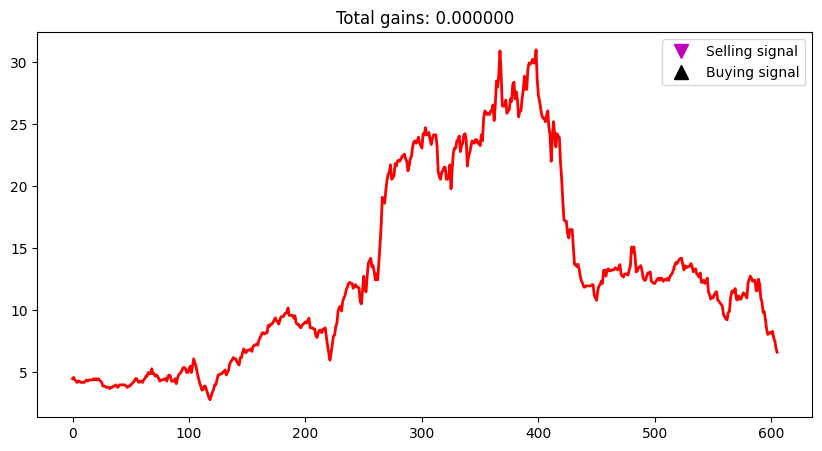

(0, [], [])

In [55]:
data = X_test
test_agent(data, window_size=5, episode_count=4)

Looking at the results above, our model resulted in an overall profit of $1280, and we can say that our DQN agent performs quite well on the test set. However, the performance of the model can be further improved by optimizing the hyperparameters as discussed in the model tuning section before. Also, given high complexity and low interpretability of the model, ideally there should be more tests conducted on different time periods before deploying the model for live trading.

**Conclusion**

We observed that we don’t have to decide the strategy or policy
for trading. The algorithm decides the policy by itself, and the overall approach is
much simpler and more principled than the supervised learning-based approach.

The
policy can be parameterized by a complex model, such as a deep neural network, and
we can learn policies that are more complex and powerful than any rules a human
trader.

We used the testing set to evaluate the model and found an overall profit in the test set.